In [35]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

---
# 데이터 로드 및 전처리
---

In [2]:
def load_data():
    # 매매기준율 데이터 로드 및 전처리 코드
    df = pd.read_csv('../sql_data/mama.csv', sep='\t', dtype=str)
    df.columns = ['createdAt,data']
    df = df['createdAt,data'].str.split(',', n=1, expand=True)
    df.columns = ['createdAt', 'data']
    
    # JSON 파싱 함수
    def parse_json(json_str, created_at=None):
        try:
            # 앞부분 따옴표 제거
            json_str = json_str.replace('"{"result":', '{"result":')
            # 뒷부분 따옴표 제거
            if json_str.endswith('}]}"'): # '}]}"'로 끝나는지 확인
                json_str = json_str[:-1]
            data = json.loads(json_str)
            result_df = pd.DataFrame(data['result'])
            # 시간 추가
            if created_at is not None:
                result_df['createdAt'] = created_at
            return result_df
        except Exception as e:
            return None

    # 전체 데이터 처리
    parsed_data = []
    for _, row in df.iterrows(): # 각 행 순회
        result = parse_json(row['data'], row['createdAt'])
        if result is not None:
            result['createdAt'] = pd.to_datetime(result['createdAt'], format='%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=9) # UTC -> KST
            parsed_data.append(result)
    
    final_df = pd.concat(parsed_data, ignore_index=True)
    
    return final_df

In [3]:
df = load_data()
df.describe()

cashSellingPrice  cashBuyingPrice  ttBuyingPrice  ttSellingPrice  \
count     741384.000000    741384.000000  741384.000000   741384.000000   
mean         587.819453       649.157568     531.387320      528.506112   
min            0.000000         0.000000       0.000000        0.000000   
25%            8.050000         9.830000       3.600000        0.000000   
50%          186.815000       206.345000     125.020000       69.940000   
75%          914.630000       947.210000     809.530000      825.870000   
max         4397.400000      5090.460000    4731.990000     4827.570000   
std          928.928720      1054.682761     969.927311      994.827912   

        currencyUnit      basePrice                      createdAt  
count  741384.000000  741384.000000                         741384  
mean        8.071562     632.249202  2025-01-19 19:34:17.108333056  
min         1.000000       0.410000            2025-01-03 02:00:57  
25%         1.000000      28.870000            2025-01-13 23:34:10  
50%         1.000000     200.310000            2025-01-20 02:44:10  
75%         1.000000     930.920000            2025-01-26 05:52:09  
max       100.000000    4779.780000            2025-02-01 08:58:09  
std        25.496638     991.349329                            NaN

In [4]:
usd = df[df['currencyCode'] == 'USD']
usd = usd[['currencyCode', 'basePrice', 'createdAt']]
usd

currencyCode  basePrice           createdAt
0               USD     1473.0 2025-01-03 02:00:57
42              USD     1473.0 2025-01-03 02:05:09
84              USD     1473.0 2025-01-03 02:10:09
126             USD     1473.0 2025-01-03 02:15:09
168             USD     1473.0 2025-01-03 02:20:10
...             ...        ...                 ...
741174          USD     1457.5 2025-02-01 08:50:10
741216          USD     1457.5 2025-02-01 08:52:09
741258          USD     1457.5 2025-02-01 08:54:09
741300          USD     1457.5 2025-02-01 08:56:09
741342          USD     1457.5 2025-02-01 08:58:09

[17654 rows x 3 columns]

In [5]:
jpy = df[df['currencyCode'] == 'JPY']
jpy = jpy[['currencyCode', 'basePrice', 'createdAt']]
jpy

currencyCode  basePrice           createdAt
1               JPY     934.38 2025-01-03 02:00:57
43              JPY     934.38 2025-01-03 02:05:09
85              JPY     934.38 2025-01-03 02:10:09
127             JPY     934.38 2025-01-03 02:15:09
169             JPY     934.38 2025-01-03 02:20:10
...             ...        ...                 ...
741175          JPY     939.35 2025-02-01 08:50:10
741217          JPY     939.35 2025-02-01 08:52:09
741259          JPY     939.35 2025-02-01 08:54:09
741301          JPY     939.35 2025-02-01 08:56:09
741343          JPY     939.35 2025-02-01 08:58:09

[17653 rows x 3 columns]

---
# 시계열 시각화
---

In [6]:
# function
def plot_time_series(df, currency_code):
    plt.figure(figsize=(12, 6))
    plt.plot(df['createdAt'], df['basePrice'], label=currency_code)
    plt.title(f'{currency_code} Time series')
    plt.xlabel('Date')
    plt.ylabel('Base Price')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

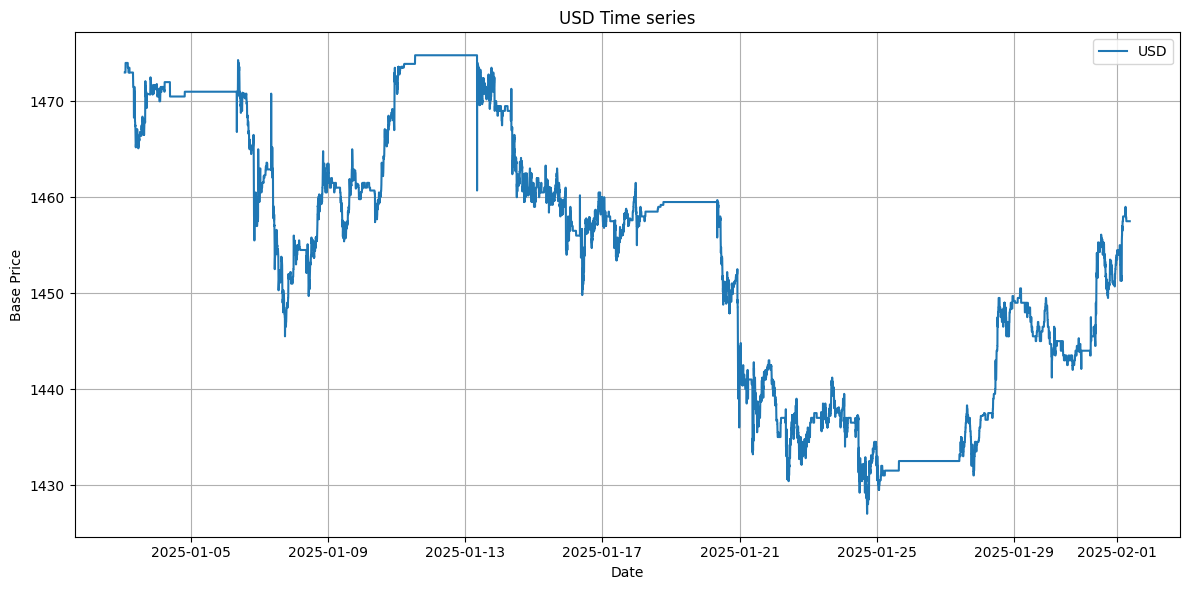

In [7]:
# USD
plot_time_series(usd, 'USD')

In [8]:
# function
def plot_time_series_sns(df, currency_code):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='createdAt', y='basePrice', data=df, label=currency_code)
    plt.title(f'{currency_code} Time series')
    plt.xlabel('Date')
    plt.ylabel('Base Price')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

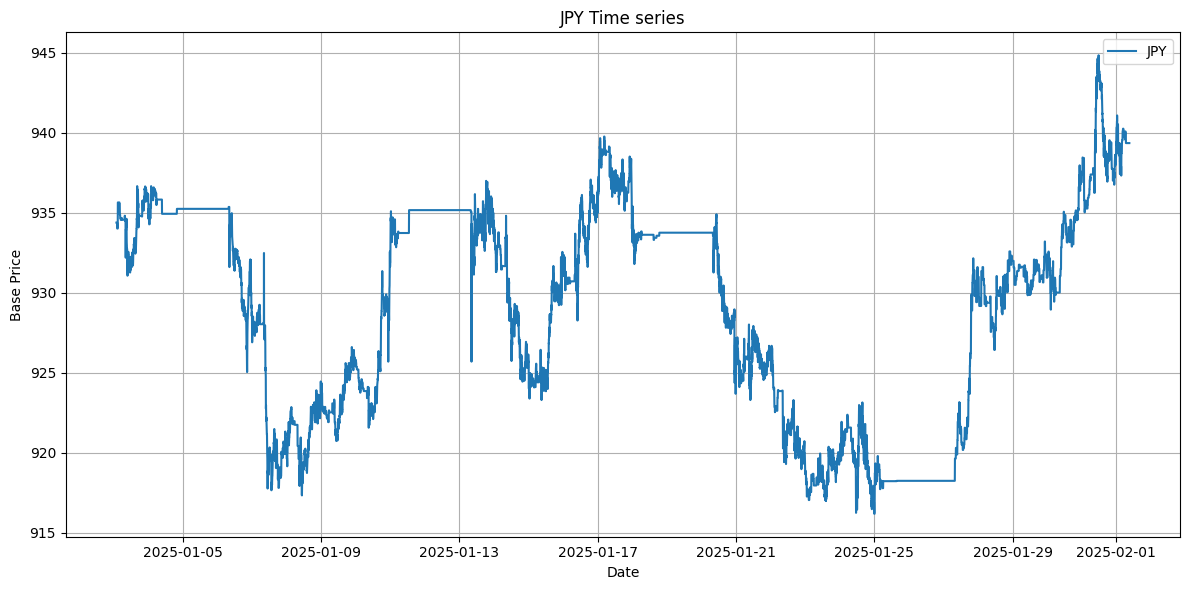

In [9]:
# jpy
plot_time_series_sns(jpy, 'JPY')

In [107]:
# function
def plot_time_series_px(df, currency_code):
    fig = px.line(df, x='createdAt', y='basePrice', title=f'{currency_code} Time series')  # Plotly를 사용한 시각화
    fig.update_layout(xaxis_title='Date', yaxis_title='Base Price')  # 축 제목 설정
    fig.show()

In [108]:
plot_time_series_px(usd, 'USD')

In [109]:
plot_time_series_px(jpy, 'JPY')

In [110]:
fillter_usd = usd[(usd['createdAt'].dt.hour >=9) | (usd['createdAt'].dt.hour < 2)].copy()

In [111]:
fillter_usd

currencyCode  basePrice           createdAt
3528            USD     1471.0 2025-01-03 09:00:09
3570            USD     1468.2 2025-01-03 09:05:13
3612            USD     1467.9 2025-01-03 09:10:09
3654            USD     1467.8 2025-01-03 09:15:11
3696            USD     1467.4 2025-01-03 09:20:12
...             ...        ...                 ...
732354          USD     1454.5 2025-02-01 01:50:11
732396          USD     1455.0 2025-02-01 01:52:10
732438          USD     1455.0 2025-02-01 01:54:09
732480          USD     1455.0 2025-02-01 01:56:09
732522          USD     1455.0 2025-02-01 01:58:09

[12362 rows x 3 columns]

In [112]:
fillter_usd.describe()

basePrice                      createdAt
count  12362.000000                          12362
mean    1452.207596  2025-01-19 19:30:19.402281216
min     1427.000000            2025-01-03 09:00:09
25%     1438.300000  2025-01-13 22:52:39.249999872
50%     1454.350000            2025-01-19 23:57:10
75%     1460.900000            2025-01-26 00:57:40
max     1474.800000            2025-02-01 01:58:09
std       13.857920                            NaN

In [113]:
fillter_usd.loc[:, 'diff'] = fillter_usd['basePrice'].diff().abs()
fillter_usd

currencyCode  basePrice           createdAt  diff
3528            USD     1471.0 2025-01-03 09:00:09   NaN
3570            USD     1468.2 2025-01-03 09:05:13   2.8
3612            USD     1467.9 2025-01-03 09:10:09   0.3
3654            USD     1467.8 2025-01-03 09:15:11   0.1
3696            USD     1467.4 2025-01-03 09:20:12   0.4
...             ...        ...                 ...   ...
732354          USD     1454.5 2025-02-01 01:50:11   0.5
732396          USD     1455.0 2025-02-01 01:52:10   0.5
732438          USD     1455.0 2025-02-01 01:54:09   0.0
732480          USD     1455.0 2025-02-01 01:56:09   0.0
732522          USD     1455.0 2025-02-01 01:58:09   0.0

[12362 rows x 4 columns]

In [114]:
px.line(fillter_usd, x='createdAt', y='diff', title='test')

In [115]:
def plot_weekly_subplots(df):
    df['week'] = df['createdAt'].dt.to_period('W').astype(str)
    weeks = df['week'].unique()
    num_weeks = len(weeks)

    num_cols = 1
    num_rows = (num_weeks + num_cols - 1) // num_cols
    fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=weeks)

    for i, week in enumerate(weeks):
        week_data = df[df['week'] == week]
        fig.add_trace(
            go.Scatter(x=week_data['createdAt'], y=week_data['diff'], mode='lines', name=week),
            row=(i // num_cols) + 1,
            col=(i % num_cols) + 1
        )

    fig.update_layout(title_text='weekly', height=600 * num_rows, showlegend=False)
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='diff')
    fig.show()


In [116]:
plot_weekly_subplots(fillter_usd)

In [117]:
time_slot_diff = fillter_usd.groupby(fillter_usd['createdAt'].dt.hour)['diff'].mean().reset_index()
px.line(time_slot_diff, x='createdAt', y='diff', title='test')

In [137]:
day_slot_diff = fillter_usd.groupby(fillter_usd['createdAt'].dt.day)['diff'].mean().reset_index()
px.line(day_slot_diff, x='createdAt', y='diff', title='test')

In [118]:
def calculate_price_difference(df, hour):
    # 2시간 뒤의 basePrice를 가져오기 위해 createdAt을 기준으로 정렬
    df = df.sort_values(by='createdAt')
    
    # 2시간 뒤의 basePrice 계산
    df[f'basePrice_{hour}h_later'] = df['basePrice'].shift(-hour)  # 2시간 뒤의 basePrice
    df['price_diff'] = df[f'basePrice_{hour}h_later'] - df['basePrice']  # 차이 계산
    df['price_diff'] = df['price_diff'].abs()
    return df

# 시각화
def plot_price_difference(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['createdAt'], y=df['price_diff'], mode='lines', name='Price Difference'))
    
    fig.update_layout(title='Price Difference',
                      xaxis_title='Date',
                      yaxis_title='Price Difference',
                      showlegend=True)
    
    fig.show()

In [119]:
fillter_usd_with_diff = calculate_price_difference(fillter_usd, 2)

In [120]:
fillter_usd_with_diff

currencyCode  basePrice           createdAt  diff  \
3528            USD     1471.0 2025-01-03 09:00:09   NaN   
3570            USD     1468.2 2025-01-03 09:05:13   2.8   
3612            USD     1467.9 2025-01-03 09:10:09   0.3   
3654            USD     1467.8 2025-01-03 09:15:11   0.1   
3696            USD     1467.4 2025-01-03 09:20:12   0.4   
...             ...        ...                 ...   ...   
732354          USD     1454.5 2025-02-01 01:50:11   0.5   
732396          USD     1455.0 2025-02-01 01:52:10   0.5   
732438          USD     1455.0 2025-02-01 01:54:09   0.0   
732480          USD     1455.0 2025-02-01 01:56:09   0.0   
732522          USD     1455.0 2025-02-01 01:58:09   0.0   

                         week  basePrice_2h_later  price_diff  
3528    2024-12-30/2025-01-05              1467.9         3.1  
3570    2024-12-30/2025-01-05              1467.8         0.4  
3612    2024-12-30/2025-01-05              1467.4         0.5  
3654    2024-12-30/2025-01-05              1467.5         0.3  
3696    2024-12-30/2025-01-05              1466.5         0.9  
...                       ...                 ...         ...  
732354  2025-01-27/2025-02-02              1455.0         0.5  
732396  2025-01-27/2025-02-02              1455.0         0.0  
732438  2025-01-27/2025-02-02              1455.0         0.0  
732480  2025-01-27/2025-02-02                 NaN         NaN  
732522  2025-01-27/2025-02-02                 NaN         NaN  

[12362 rows x 7 columns]

In [121]:
plot_price_difference(fillter_usd_with_diff)

In [122]:
fillter_usd_with_diff_3 = calculate_price_difference(fillter_usd, 3)
plot_price_difference(fillter_usd_with_diff_3)

In [130]:
def plot_weekly_subplots_hour(df):
    df['week'] = df['createdAt'].dt.to_period('W').astype(str)
    weeks = df['week'].unique()
    num_weeks = len(weeks)

    num_cols = 1
    num_rows = (num_weeks + num_cols - 1) // num_cols
    fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=weeks)

    for i, week in enumerate(weeks):
        week_data = df[df['week'] == week]
        fig.add_trace(
            go.Scatter(x=week_data['createdAt'], y=week_data['price_diff'], mode='lines', name=week),
            row=(i // num_cols) + 1,
            col=(i % num_cols) + 1
        )

    fig.update_layout(title_text='weekly', height=600 * num_rows, showlegend=False)
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='diff')
    fig.show()


In [131]:
plot_weekly_subplots_hour(fillter_usd_with_diff)

In [132]:
plot_weekly_subplots_hour(fillter_usd_with_diff_3)

In [134]:
df_resampled = fillter_usd_with_diff.resample("1h", on='createdAt')['diff'].mean().dropna()
df_resampled.head(50)

createdAt
2025-01-03 09:00:00    0.581818
2025-01-03 10:00:00    0.366667
2025-01-03 11:00:00    0.275000
2025-01-03 12:00:00    0.150000
2025-01-03 13:00:00    0.175000
2025-01-03 14:00:00    0.250000
2025-01-03 15:00:00    0.358333
2025-01-03 16:00:00    0.658333
2025-01-03 17:00:00    0.542857
2025-01-03 19:00:00    0.400000
2025-01-03 20:00:00    0.191667
2025-01-03 21:00:00    0.133333
2025-01-03 22:00:00    0.166667
2025-01-03 23:00:00    0.066667
2025-01-04 00:00:00    0.191667
2025-01-04 01:00:00    0.133333
2025-01-04 09:00:00    0.208333
2025-01-04 10:00:00    0.000000
2025-01-04 11:00:00    0.000000
2025-01-04 12:00:00    0.000000
2025-01-04 13:00:00    0.000000
2025-01-04 14:00:00    0.000000
2025-01-04 15:00:00    0.000000
2025-01-04 16:00:00    0.000000
2025-01-04 17:00:00    0.000000
2025-01-04 18:00:00    0.000000
2025-01-04 19:00:00    0.000000
2025-01-04 20:00:00    0.041667
2025-01-04 21:00:00    0.000000
2025-01-04 22:00:00    0.000000
2025-01-04 23:00:00    0.00000

In [135]:
px.line(df_resampled, x=df_resampled.index, y=df_resampled.values)